In [1]:
%matplotlib inline
import sys
from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries, Arima, AutoArima
from u8timeseries.models.autoregressive_model import AutoRegressiveModel
from u8timeseries import StandardRegressiveModel
from u8timeseries.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting import simulate_forecast_ar, simulate_forecast_regr, get_train_val_series, backtest_autoregressive_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

import hyperopt as hpt 
import pandas as pd
pd.__version__
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from numpy.random import seed
from tensorflow import set_random_seed

from hyperopt.pyll.base import scope
@scope.define
def to_int(x):
    return int(x)

I0828 09:09:57.766460 140322427553600 utils.py:23] Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.
I0828 09:09:57.772182 140322427553600 fmin.py:28] Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.


## Read data

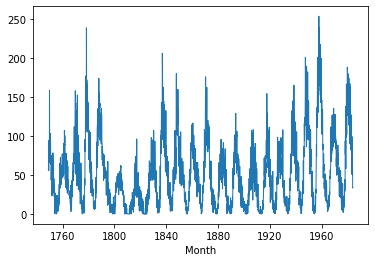

In [2]:
df = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', 'Sunspots')
series.plot(lw=1)

In [3]:
class LSTMModel(AutoRegressiveModel):
    def __init__(self, lstm_hidden_sizes=[20], dense_hidden_sizes=[1], dropout=0.0,
            recurrent_dropout=0.0,
            epochs=10, batch_size=1, back_steps=3, forecast_steps=3, validation_split=0.0):
        super().__init__()
        print("NEW MODEL")
        # Stores training date information:
        self.training_series: TimeSeries = None
        self.lstm_hidden_sizes = lstm_hidden_sizes
        self.dense_hidden_sizes = dense_hidden_sizes
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.back_steps = back_steps
        self.forecast_steps = forecast_steps
        self.validation_split = validation_split
        # state
        self._fit_called = False

    def __split_dataset(self, series, back_steps):
        data_in, data_out = [], []
        for i in range(len(series) - back_steps - 1):
            data_in.append(series[i:(i + back_steps)])
            data_out.append(series[i + back_steps])
        data_in = np.array(data_in, dtype=np.float32)
        data_out = np.array(data_out, dtype=np.float32)
        data_in = data_in.reshape(data_in.shape[0], data_in.shape[1], 1)
        data_out = data_out.reshape(-1, 1)
        return data_in, data_out

    def fit(self, series: TimeSeries) -> None:
        super().fit(series)
        self.model = Sequential()
        for size in self.lstm_hidden_sizes[:-1]:
            self.model.add(LSTM(size, return_sequences=True, recurrent_dropout=self.recurrent_dropout))
        self.model.add(LSTM(self.lstm_hidden_sizes[-1]))
        for size in self.dense_hidden_sizes:
            self.model.add(Dropout(self.dropout))
            self.model.add(Dense(size, activation='relu'))
        self.model.compile(loss="mean_absolute_error", optimizer="adam")
        
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.training_series = series
        self.scaled_series = self.scaler.fit_transform(series.values().reshape(-1, 1))
        data_in, data_out = self.__split_dataset(self.scaled_series, self.back_steps)
        self.model.fit(data_in, data_out, epochs=self.epochs, batch_size=self.batch_size, shuffle=False,
                      validation_split=self.validation_split, verbose=0)
        self._fit_called = True

    def predict(self, n: int) -> TimeSeries:
        super().predict(n)
        in_values = self.scaled_series[-self.back_steps:]
        predictions = []
        for i in range(n):
            pred = self.model.predict(in_values.reshape(1, in_values.shape[0], in_values.shape[1]))
            in_values = np.concatenate([in_values, pred], axis=0)
            in_values = in_values[1:]
            predictions.append(pred)
        predictions = np.array(predictions).reshape(-1, 1)
        predictions = self.scaler.inverse_transform(predictions).reshape(-1)
        return self._build_forecast_series(predictions)

In [4]:
train_series, test_series = series.split_after(pd.Timestamp('19571201'))

In [ ]:
model_lstm = LSTMModel(lstm_hidden_sizes=[25], dense_hidden_sizes=[1], dropout=0.36043224563914095,
                    recurrent_dropout=0.0,
                    epochs=40, batch_size=32, back_steps=32, forecast_steps=12)
tf.reset_default_graph()
seed(47)
set_random_seed(47)
sess = tf.Session()
with sess.as_default():
    K.set_session(sess)
    train_series, test_series = series.split_after(pd.Timestamp('19571201'))
    print(train_series.values().shape, test_series.values().shape)
    model_lstm.fit(train_series)
    pred = model_lstm.predict(len(test_series))
    train_series.plot(lw=2, label='train')
    test_series.plot(lw=2, label='true')
    pred.plot(lw=2, label='prediction')
    plt.legend()
    mse = (np.square(test_series.values() - pred.values())).mean()
    print("Test: {}".formt(mse))
sess.close()


In [ ]:
#hyperopt library looks for "the best" hyperparameters
K.clear_session()
def objective(values_dict):
    tf.reset_default_graph()
    seed(47)
    set_random_seed(47)
    sess = tf.Session()
    with sess.as_default():
        K.set_session(sess)
        print(values_dict)
        model_lstm = LSTMModel(lstm_hidden_sizes=[values_dict['hidden_size'] for i in range(2)], 
                           dense_hidden_sizes=[1], 
                           dropout=values_dict['dropout'],
                           recurrent_dropout=0.0,
                           epochs=60, 
                           batch_size=16, 
                           back_steps=30, 
                           forecast_steps=16)
        model_lstm.fit(train_series)
        pred = model_lstm.predict(len(test_series))
    sess.close()
    loss = (np.square(test_series.values() - pred.values())).mean()
    return loss
    
space = {
            'hidden_size': 20 + hpt.hp.randint('hidden_size', 150), 
            'dropout': hpt.hp.uniform('dropout', 0.1, 0.5)
        }

trials = hpt.Trials()
best = hpt.fmin(objective,
              space=space,
              algo=hpt.tpe.suggest,
              max_evals=60,
              trials=trials)

print(best)

## Simulate historical forecasting
Here we'll do some backtesting. We will simulate predictions that would have been done historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 6 months in the future (compared to prediction time).

In [ ]:
historical_fcast = simulate_forecast_ar(series, model_lstm, pd.Timestamp('19830401'), fcast_horizon_n=6, verbose=True)

Let's see what this backtest forecast looks like. You can see it produces more accurate predictions than the one-off prediction done above, because here the model is re-fit every month.

In [ ]:
plt.figure(figsize=(8,6))
series.plot(label='data')
historical_fcast.plot(lw=3, label='backtest 6-months ahead forecast')
plt.legend()

## Backtest the models on the data using a user-defined metric
Here we'll do slightly more advanced backtesting, and use our own metric (in this case the MAPE error function) to compare the different models. We'll simulate 12-months ahead predictions done in the past, starting in January 1955, and the errors will be computed on the 12-months period for which forecasts are done.

In [ ]:
def backtest_model(model):
    tic = time.time()
    train_val_series = get_train_val_series(series, start=pd.Timestamp('19550101'), nr_points_val=12)
    res = backtest_autoregressive_model(model, train_val_series, mape)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

In [ ]:
res_es = backtest_model(model_es)
res_pr = backtest_model(model_pr)
res_bl = backtest_model(model_bl)

### Plot the user-defined backtesting results

In [ ]:
plt.hist(res_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(res_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');
plt.hist(res_bl, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Baseline');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=4)

### Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

In [ ]:
model_es.fit(series)
pred = model_es.predict(n = 50)

series.plot(label='data', lw=2)
pred.plot(label='forecast', lw=2)
plt.legend()

## Ensembling several predictions
### Let's simulate forecasts done by an ensemble of models

In [ ]:
""" New way - backtest over time
"""
models = [ExponentialSmoothing(), Prophet()]

historical_ar_preds = [simulate_forecast_ar(series, m, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)
                       for m in models]

In [ ]:
""" Combine the individual simulated predicitons
"""
regrModel = StandardRegressiveModel(train_n_points=12)

series_val = series.intersect(historical_ar_preds[0])

historical_pred = simulate_forecast_regr(historical_ar_preds, series_val, regrModel,
                                         pd.Timestamp('19580101'), fcast_horizon_n=6)

In [ ]:
""" Compute errors and plot
"""
plt.figure(figsize=(8,5))

series.plot()
for i, m in enumerate(models):
    historical_ar_preds[i].plot(label=str(m))
    
    # intersect last part, to compare everything with ensemble
    ar_pred = historical_ar_preds[i].intersect(historical_pred)
       
    mape_er = mape(series.intersect(historical_pred), ar_pred)
    print('MAPE Error {}: {}'.format(m, mape_er))

print('MAPE Error ensemble: {}'.format(mape(series.intersect(historical_pred), historical_pred)))

historical_pred.plot(label='Ensemble')

plt.legend()

## Example of forecasting using a regressive model and extra features